# Generalised Additive Model - analysis of relationship between DToCs and ED breaches

Imports

In [1]:
require(mgcv)
require(nlme)
require(car)
library(data.table)
library(ggplot2)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.
Loading required package: car


Read in and process data

In [2]:
#data = read.csv("input/20180913_diff_dtoc.csv")
dtoc = read.csv("input/dtoc.csv")

In [3]:
dtoc$yr = as.numeric(substr(dtoc$year, 1, 4))

In [4]:
head(dtoc)

year,month,total_atten,total_atten_t1,total_atten_.4hr,X95._targ,total_admissions,dtoc_a,dtoc_na,dtoc_total,mth,time,yr
2010-11,August,1719197,1138652,33184,0.9806980,425702.0,2559,2381,4940,8,1,2010
2010-11,September,1715117,1150728,41151,0.9760069,424900.0,2647,2357,5004,9,2,2010
2010-11,October,1753934,1163143,47414,0.9729671,436215.0,2513,2075,4588,10,3,2010
2010-11,November,1604591,1111295,46436,0.9710603,429099.0,2352,2057,4409,11,4,2010
2010-11,December,1647824,1159204,89917,0.9454327,452728.7,1995,1866,3861,12,5,2010
2010-11,January,1654907,1133881,72889,0.9559557,442003.7,2563,2034,4597,1,6,2010


In [99]:
summary(dtoc)$

      year         month     total_atten      total_atten_t1   
 2010-11: 8   August  : 7   Min.   :1519203   Min.   :1053707  
 2011-12:12   December: 7   1st Qu.:1684770   1st Qu.:1158545  
 2012-13:12   February: 7   Median :1740479   Median :1213561  
 2013-14:12   January : 7   Mean   :1737679   Mean   :1207930  
 2014-15:12   March   : 7   3rd Qu.:1802397   3rd Qu.:1251347  
 2015-16:12   November: 7   Max.   :1910700   Max.   :1353477  
 2016-17:12   (Other) :38                                      
 total_atten_.4hr   X95._targ      total_admissions     dtoc_a    
 Min.   : 33184   Min.   :0.8255   Min.   :401206   Min.   :1995  
 1st Qu.: 64034   1st Qu.:0.9158   1st Qu.:427653   1st Qu.:2402  
 Median : 89509   Median :0.9480   Median :448185   Median :2676  
 Mean   :110424   Mean   :0.9361   Mean   :450436   Mean   :2976  
 3rd Qu.:142784   3rd Qu.:0.9649   3rd Qu.:467992   3rd Qu.:3371  
 Max.   :281612   Max.   :0.9807   Max.   :509805   Max.   :4781  
                   

Preliminary look at time series

In [5]:
ts_breach = ts(dtoc$total_atten_.4hr)
ts_dtoc = ts(dtoc$dtoc_total)
ts_attend = ts(dtoc$total_atten_t1)
ts_admit = ts(dtoc$total_admissions)

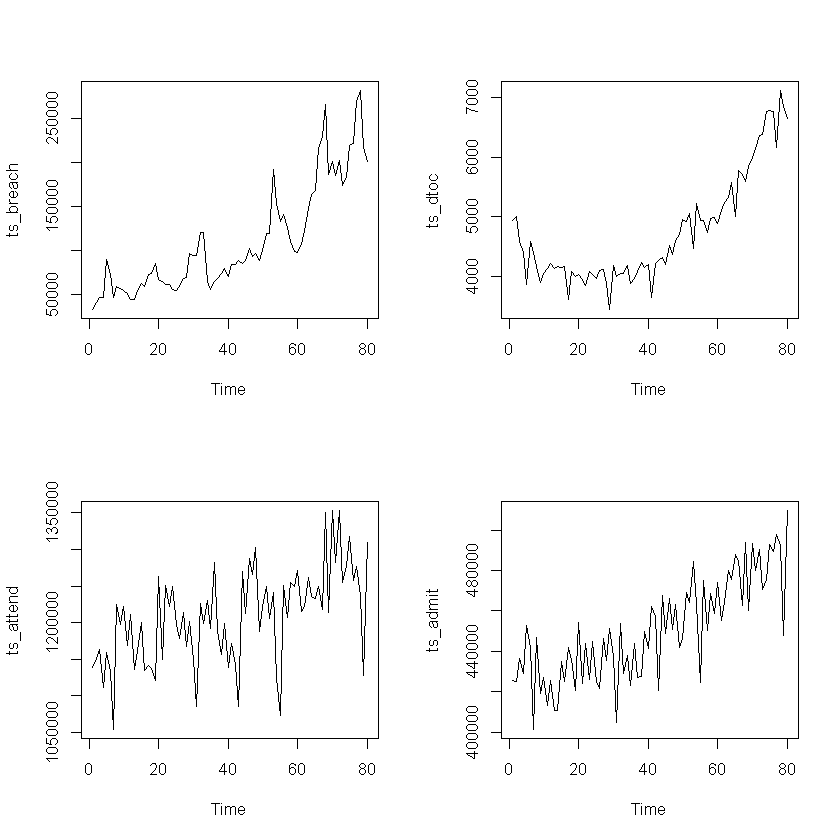

In [6]:
par(mfrow=c(2,2))
plot.ts(ts_breach,xy.lines=F,xy.labels=F) #  (increasing variance)
plot.ts(ts_dtoc,xy.lines=F,xy.labels=F)
plot.ts(ts_attend,xy.lines=F,xy.labels=F)
plot.ts(ts_admit,xy.lines=F,xy.labels=F)

## Utility functions

In [7]:
plot_fit <-function(gam, title){
    datas <- rbindlist(list(data.table(breaches = dtoc$total_atten_.4hr,time= dtoc$time),
    data.table(breaches = gam$fitted.values,time = dtoc$time)))

    datas[, type := c(rep("Real", nrow(dtoc)), rep("Fitted", nrow(dtoc)))]

    ggplot(data = datas, aes(time, breaches, group = type, colour = type)) +
      geom_line(size = 0.8) +
      theme_bw() +
      labs(x = "Time", y = "Breaches",
           title = paste("Fit from GAM",title))
    }

## Preliminary GAM models (not accounting for autocorrelation)

### Model 1: No interation between month and year 

In [106]:
m1 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6), data=dtoc, 
           family="poisson",
          method="REML")
summary(m1$gam)


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



Family: poisson 
Link function: log 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.148e+01  3.809e-04   30151   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df      F p-value    
s(mth) 10.997 10.997  30932  <2e-16 ***
s(yr)   4.998  4.998 384649  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.886   
  Scale est. = 1         n = 80

[1] "PQL"

Take a look at month and year components.

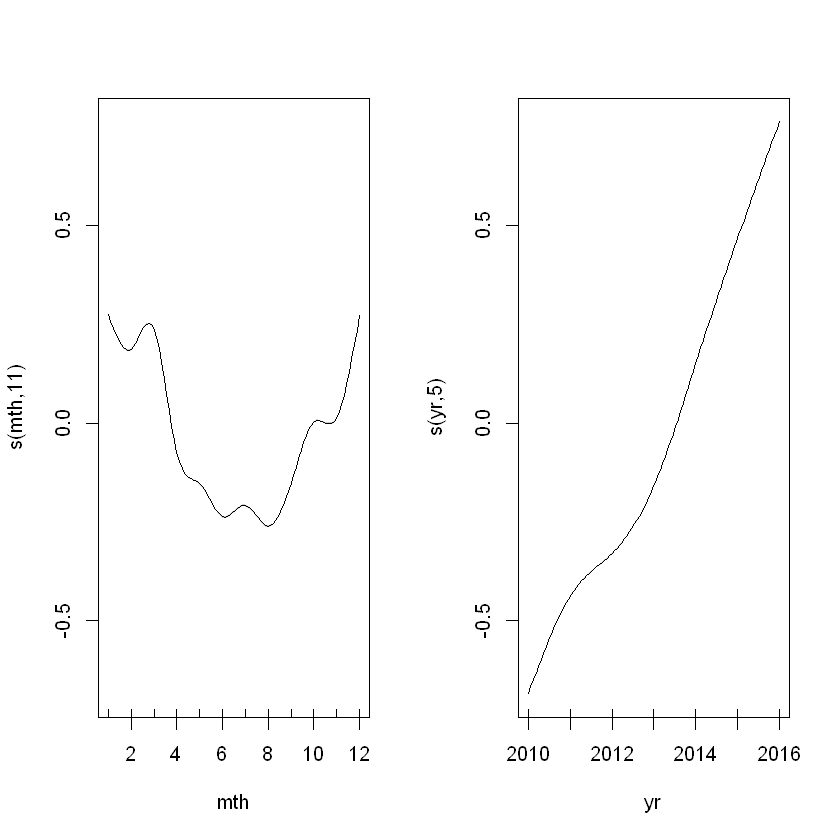

In [9]:
layout(matrix(1:2, nrow = 1))
plot(m1$gam, shade = TRUE)

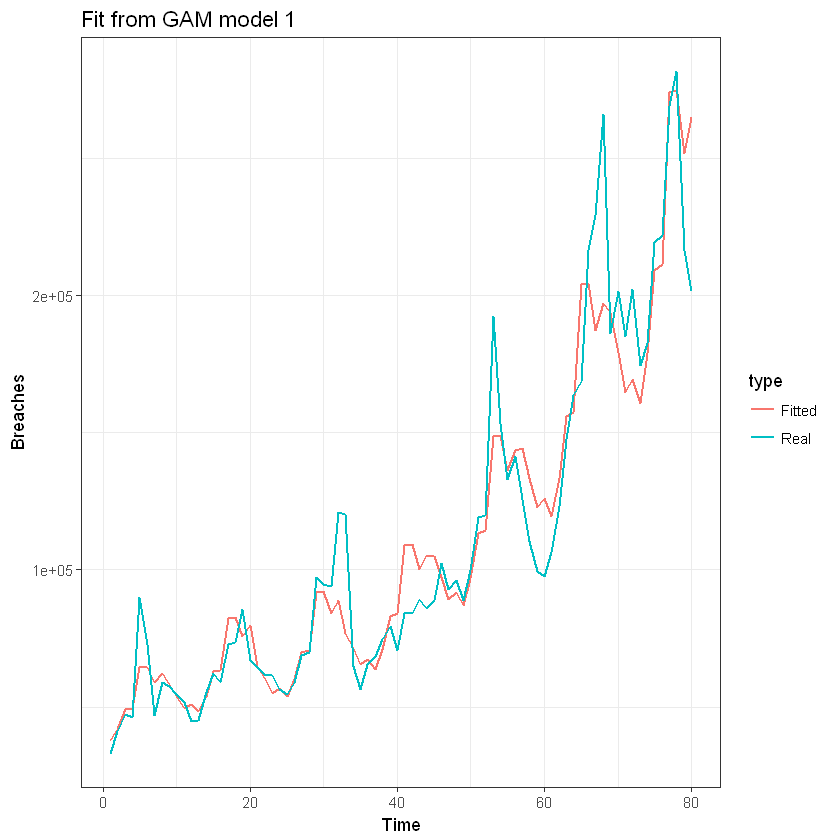

In [10]:
plot_fit(m1$gam, "model 1")

### Model 2: Month and Year Interaction (ignoring autocorrelation of resids)

In [11]:
m2 <- gamm(total_atten_.4hr ~s(mth, yr), data=dtoc, family = "poisson")
summary(m2$gam)


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



Family: poisson 
Link function: log 

Formula:
total_atten_.4hr ~ s(mth, yr)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.148e+01  3.838e-04   29916   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
            edf Ref.df     F p-value    
s(mth,yr) 28.99  28.99 77023  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.903   
  Scale est. = 1         n = 80

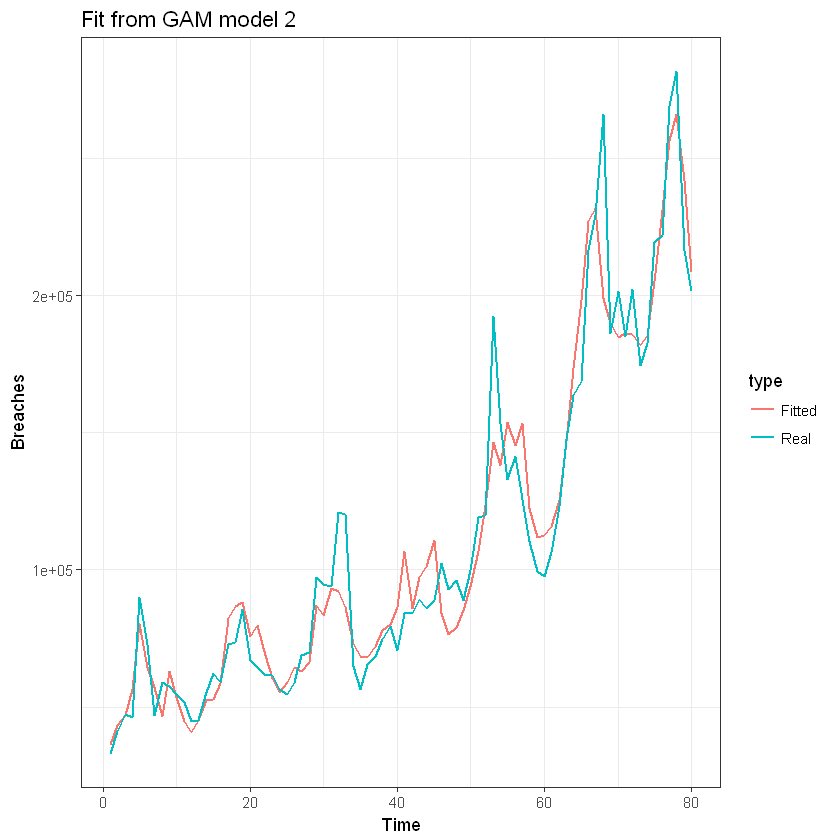

In [12]:
plot_fit(m2$gam, "model 2")

### Model 3: Tensor interactions(!?) (ignore errors)

In [13]:
m3 <- gamm(total_atten_.4hr ~ te(mth, yr, bs= c("cr", "ps")), data=dtoc, family = "poisson")
summary(m3$gam)$r.sq


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3


[1] 0.9105584

no real difference from splines

In [14]:
summary(m3$gam)$s.table

,edf,Ref.df,F,p-value
"te(mth,yr)",23.99454,23.99454,93021.68,0


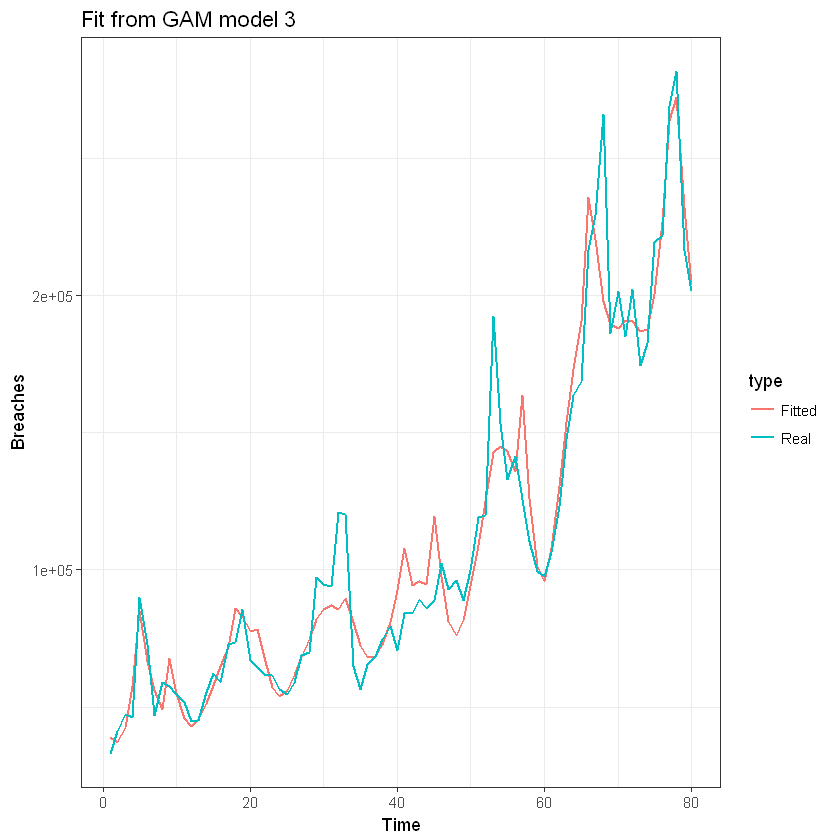

In [15]:
plot_fit(m3$gam, "model 3")

### Compare basic models

In [16]:
#anova(m1$lme, m2$lme, m3$lme)

Conclusion - anova and AIC provide no strong evidence to go for interaction model over basic.  Visually it does look like we should be including an interaction between month and year!

## GAM - introducing further predictors (ignoring autocorrelation)

In [17]:
m4 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) + dtoc_total, data=dtoc
          , family="poisson")
m5 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) + s(dtoc_total, k = 6), data=dtoc,
          family = "poisson")


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3


In [18]:
summary(m4$gam)


Family: poisson 
Link function: log 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6) + dtoc_total

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.024e+01  9.424e-03    1087   <2e-16 ***
dtoc_total  2.622e-04  1.986e-06     132   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df     F p-value    
s(mth) 10.997 10.997 26912  <2e-16 ***
s(yr)   4.999  4.999 49033  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.895   
  Scale est. = 1         n = 80

In [19]:
#anova(m4$lme, m5$lme)

cannot use anova - not valid

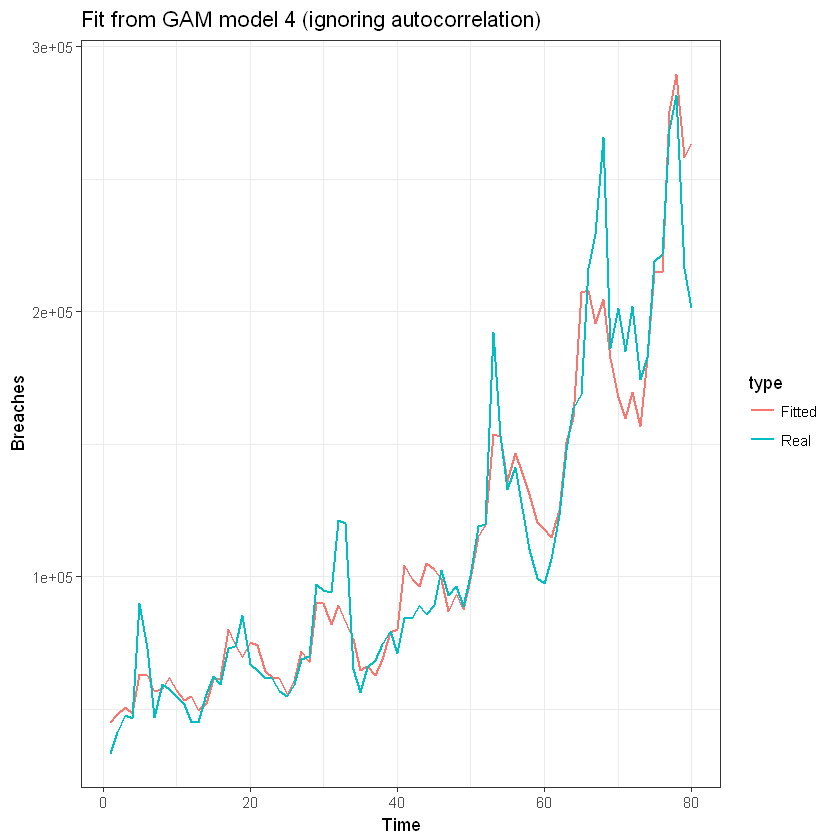

In [20]:
plot_fit(m4$gam, "model 4 (ignoring autocorrelation)")

In [21]:
m5 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions, 
           data=dtoc,
           family="poisson")

m6 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc,
          family="poisson")


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3


In [22]:
#anova(m4$lme, m5$lme, m6$lme)

In [23]:
summary(m6$gam)


Family: poisson 
Link function: log 

Formula:
total_atten_.4hr ~ s(mth, k = 12) + s(yr, k = 6) + dtoc_total + 
    total_admissions + total_atten_t1

Parametric coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       7.583e+00  1.523e-02  497.89   <2e-16 ***
dtoc_total        1.632e-04  2.178e-06   74.94   <2e-16 ***
total_admissions -2.355e-06  6.479e-08  -36.35   <2e-16 ***
total_atten_t1    3.466e-06  1.914e-08  181.12   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df     F p-value    
s(mth) 10.998 10.998 48638  <2e-16 ***
s(yr)   4.995  4.995 22796  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.937   
  Scale est. = 1         n = 80

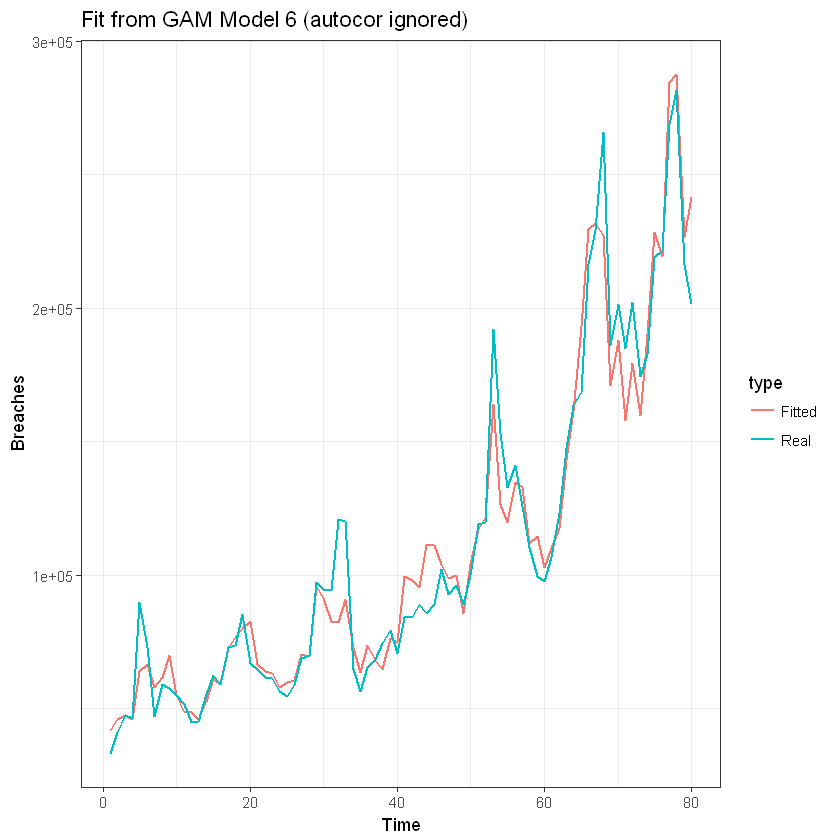

In [24]:
plot_fit(m6$gam, "Model 6 (autocor ignored)")

## GAM - modelling autocorrelation in residuals

Starting from model 6

In [51]:
m6 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total, 
           data=dtoc,
           family="poisson")

m6_p1 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total, 
           data=dtoc,
           correlation = corARMA(form = ~ 1, p = 1),
           family="poisson")


m6_p2 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           + dtoc_total, 
           data=dtoc,
           correlation = corARMA(form = ~ 1|yr, p = 2),
             family = "poisson")

m6_q1 <- gamm(total_atten_.4hr ~s(mth, k = 12) + s(yr, k=6) 
           , 
           data=dtoc,
           correlation = corARMA(form = ~ 1|yr, p = 1, q = 1),
             family = "poisson")



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3



 Maximum number of PQL iterations:  20 


iteration 1
iteration 2
iteration 3


In [93]:
m6_q1 <- gamm(total_atten_.4hr ~s(mth, k = 3) + s(yr, k=6) 
           + dtoc_total 
           + total_admissions
           + total_atten_t1, 
           data=dtoc,
           correlation = corARMA(form = ~1|yr, q = 1),
             family = "poisson")


 Maximum number of PQL iterations:  20 


iteration 1
iteration 2


In [27]:
#anova(m6$lme, m6_p1$lme, m6_p2$lme)

Conclusion - AR(1) has small, but sig improvement in AIC and BIC.

In [94]:
x = summary(m6_q1$gam)
x
confint(m6_q1$gam)


Family: poisson 
Link function: log 

Formula:
total_atten_.4hr ~ s(mth, k = 3) + s(yr, k = 6) + dtoc_total + 
    total_admissions + total_atten_t1

Parametric coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.014e+01  1.222e-02  829.70   <2e-16 ***
dtoc_total        2.149e-05  1.246e-06   17.24   <2e-16 ***
total_admissions -7.384e-06  6.107e-08 -120.91   <2e-16 ***
total_atten_t1    3.785e-06  1.857e-08  203.84   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df     F p-value    
s(mth) 2.000  2.000 71908  <2e-16 ***
s(yr)  4.995  4.995 41514  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.928   
  Scale est. = 1         n = 80

,2.5 %,97.5 %
(Intercept),1.011423e+01,1.016213e+01
dtoc_total,1.904895e-05,2.393494e-05
total_admissions,-7.504056e-06,-7.264659e-06
total_atten_t1,3.748283e-06,3.821063e-06
s(mth).1,-1.179333e+00,-1.166591e+00
s(mth).2,-5.341483e-02,-5.196527e-02
s(yr).1,6.642761e-02,7.701979e-02
s(yr).2,-8.400583e-02,-5.996668e-02
s(yr).3,-4.533252e-02,-3.737090e-02
s(yr).4,-1.269816e-01,-9.651291e-02


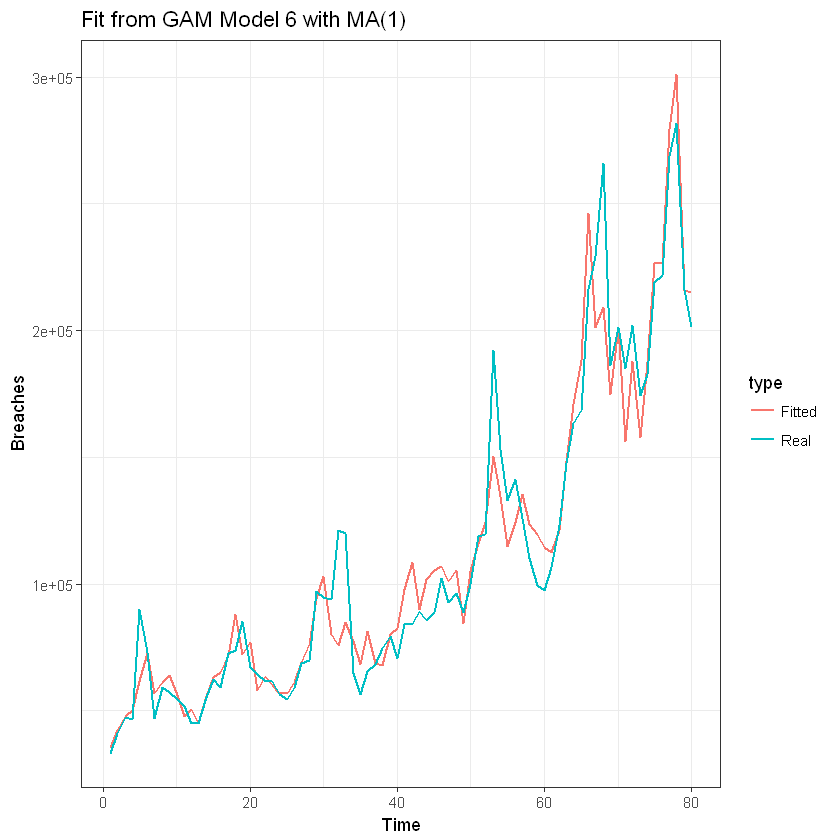

In [95]:
plot_fit(m6_q1$gam, "Model 6 with MA(1)")


'gamm' based fit - care required with interpretation.
Checks based on working residuals may be misleading.
Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

       k' edf k-index p-value   
s(mth)  2   2    1.16   0.885   
s(yr)   5   5    0.64   0.005 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


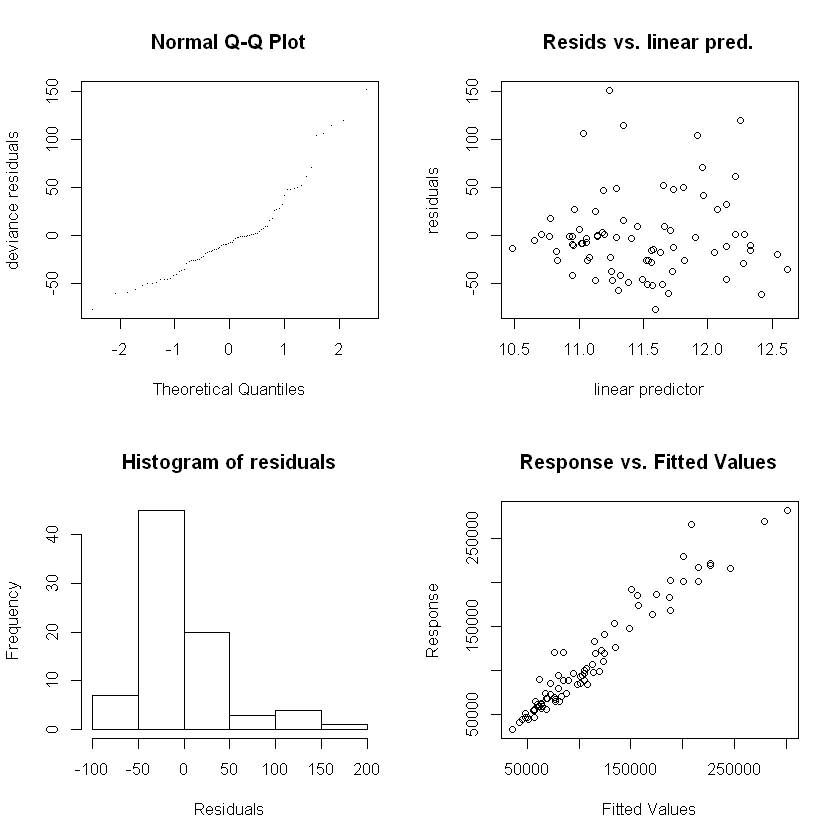

In [96]:
gam.check(m6_q1$gam)

In [37]:
tmp <- tempfile()
download.file("https://github.com/gavinsimpson/random_code/raw/master/derivFun.R",
              tmp)
source(tmp)
tmp <- tempfile()
download.file("https://github.com/gavinsimpson/random_code/raw/master/tsDiagGamm.R",
              tmp)
source(tmp)



### Diagnostics of Model 6 with AR(1)

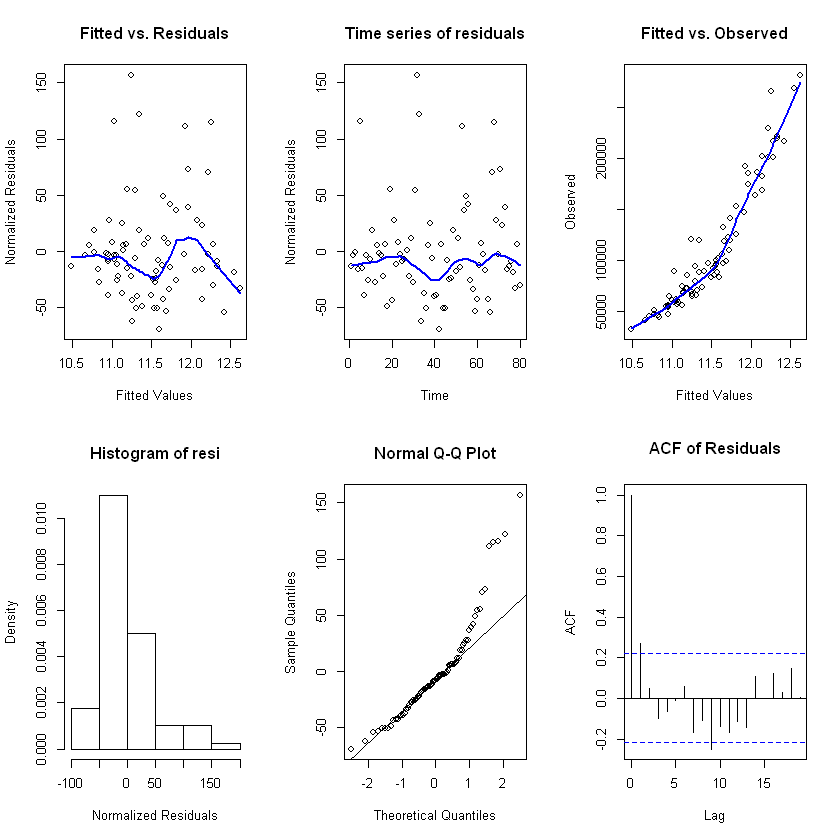

In [97]:
with(dtoc, tsDiagGamm(m6_q1, timevar = time, observed = total_atten_.4hr))


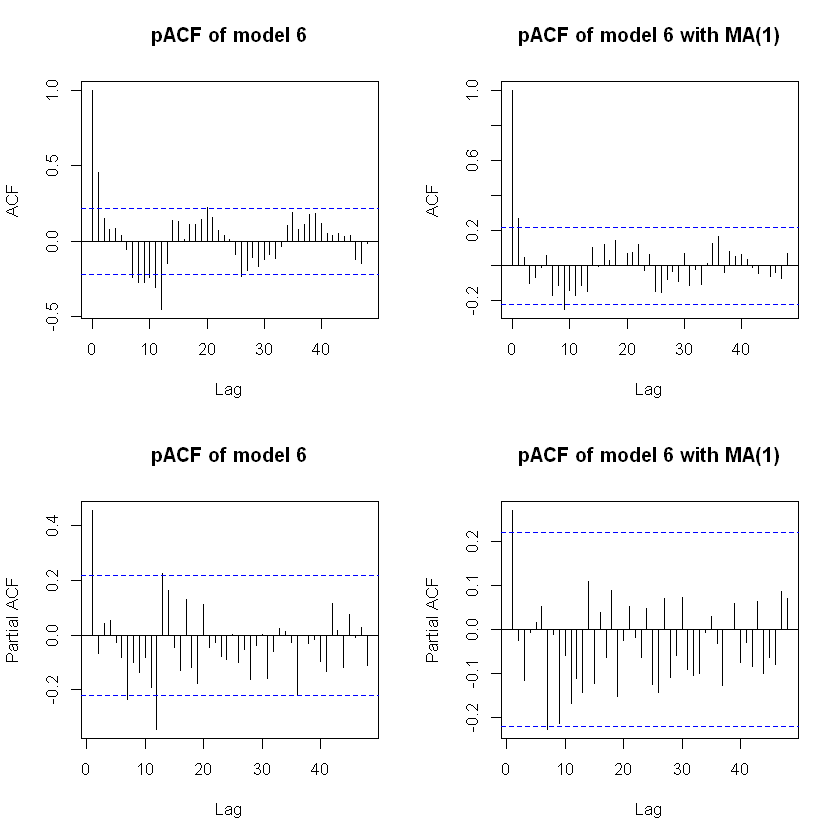

In [98]:

par(mfrow=c(2,2))
acf(resid(m6$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6")
acf(resid(m6_q1$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6 with MA(1)")
pacf(resid(m6$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6")
pacf(resid(m6_q1$lme, type = "normalized"), lag.max = 48, main = "pACF of model 6 with MA(1)")


In [72]:
library(forecast)
arma_res <- auto.arima(resid(m6$lme, type = "normalized"),
                       stationary = TRUE, seasonal = FALSE)
 
arma_res$coef

ar1 
0.4998647